In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
!unzip /content/drive/MyDrive/leather_dataset/leather_dataset.zip

Archive:  /content/drive/MyDrive/leather_dataset/leather_dataset.zip
replace content/Leather_Defect_Classification/Folding_marks/Folding_marks_01_(52).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
data_dir = "/content/content/Leather_Defect_Classification"
data_dir = pathlib.Path(data_dir).with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3600


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3600 files belonging to 6 classes.
Using 2880 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3600 files belonging to 6 classes.
Using 720 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Folding_marks', 'Grain_off', 'Growth_marks', 'loose_grains', 'non_defective', 'pinhole']


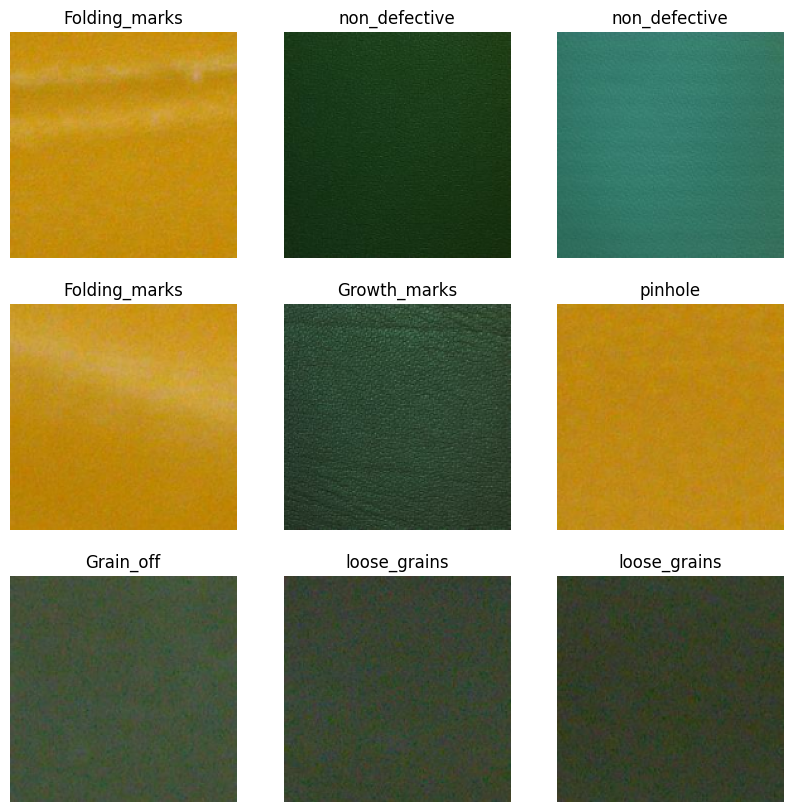

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.06413527 0.7966867


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
90/90 [==============================] - 2s 27ms/step - loss: 0.2393 - accuracy: 0.9087 - val_loss: 0.3433 - val_accuracy: 0.8528
Epoch 2/20
90/90 [==============================] - 2s 25ms/step - loss: 0.2349 - accuracy: 0.9073 - val_loss: 0.2422 - val_accuracy: 0.8958
Epoch 3/20
90/90 [==============================] - 2s 24ms/step - loss: 0.2024 - accuracy: 0.9128 - val_loss: 0.2326 - val_accuracy: 0.9097
Epoch 4/20
90/90 [==============================] - 2s 22ms/step - loss: 0.1855 - accuracy: 0.9243 - val_loss: 0.2237 - val_accuracy: 0.8972
Epoch 5/20
90/90 [==============================] - 2s 22ms/step - loss: 0.1483 - accuracy: 0.9372 - val_loss: 0.2173 - val_accuracy: 0.8972
Epoch 6/20
90/90 [==============================] - 2s 22ms/step - loss: 0.1318 - accuracy: 0.9458 - val_loss: 0.1982 - val_accuracy: 0.9139
Epoch 7/20
90/90 [==============================] - 2s 22ms/step - loss: 0.1597 - accuracy: 0.9392 - val_loss: 0.2346 - val_accuracy: 0.8875
Epoch 8/20
90

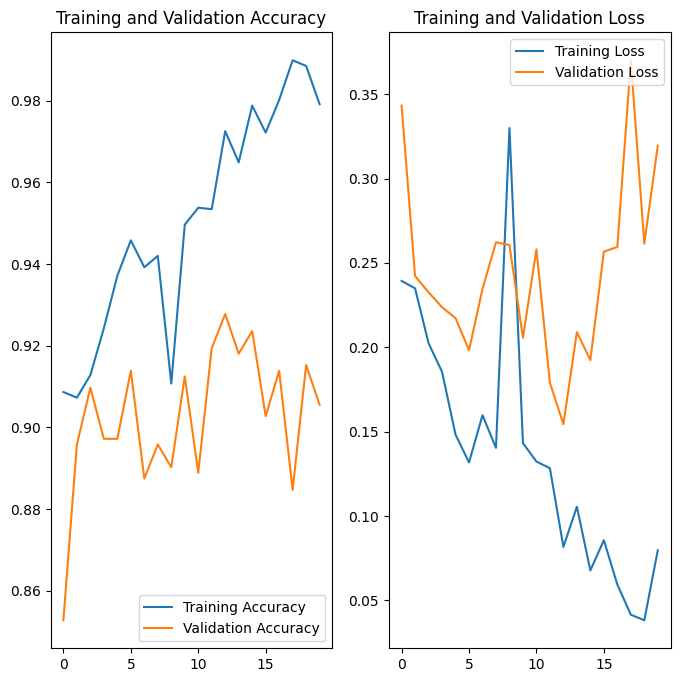

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Alternative model

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

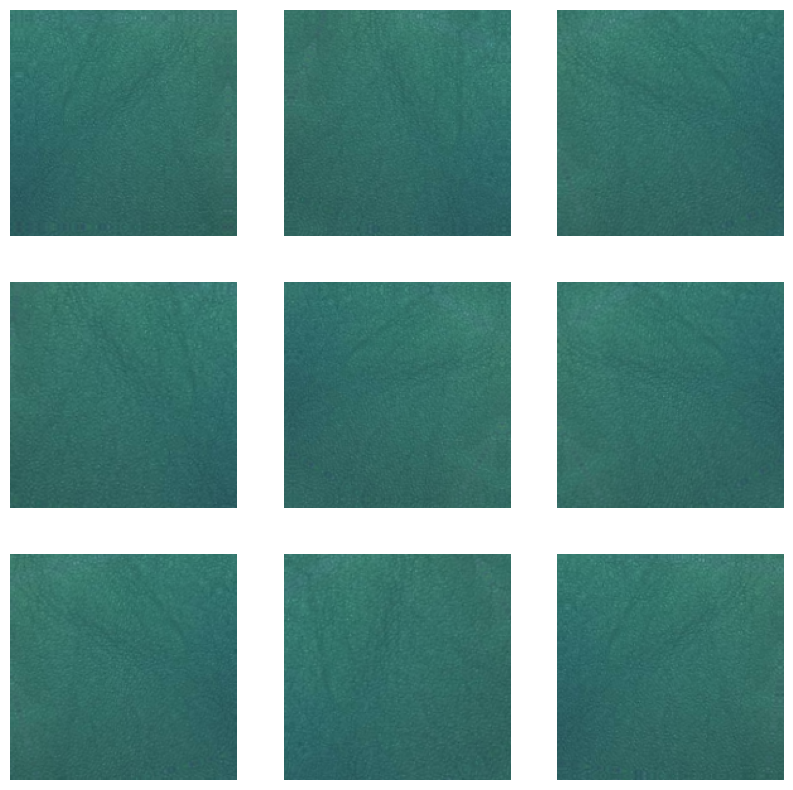

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
90/90 [==============================] - 6s 34ms/step - loss: 1.4895 - accuracy: 0.3826 - val_loss: 1.1351 - val_accuracy: 0.5056
Epoch 2/20
90/90 [==============================] - 3s 33ms/step - loss: 1.0435 - accuracy: 0.5222 - val_loss: 0.8411 - val_accuracy: 0.6542
Epoch 3/20
90/90 [==============================] - 3s 35ms/step - loss: 0.8121 - accuracy: 0.6493 - val_loss: 0.7866 - val_accuracy: 0.6181
Epoch 4/20
90/90 [==============================] - 3s 34ms/step - loss: 0.6871 - accuracy: 0.7073 - val_loss: 0.6536 - val_accuracy: 0.7458
Epoch 5/20
90/90 [==============================] - 3s 31ms/step - loss: 0.5476 - accuracy: 0.7795 - val_loss: 0.4820 - val_accuracy: 0.8153
Epoch 6/20
90/90 [==============================] - 3s 32ms/step - loss: 0.4706 - accuracy: 0.8097 - val_loss: 0.8110 - val_accuracy: 0.7125
Epoch 7/20
90/90 [==============================] - 3s 35ms/step - loss: 0.4565 - accuracy: 0.8191 - val_loss: 0.4284 - val_accuracy: 0.8167
Epoch 8/20
90

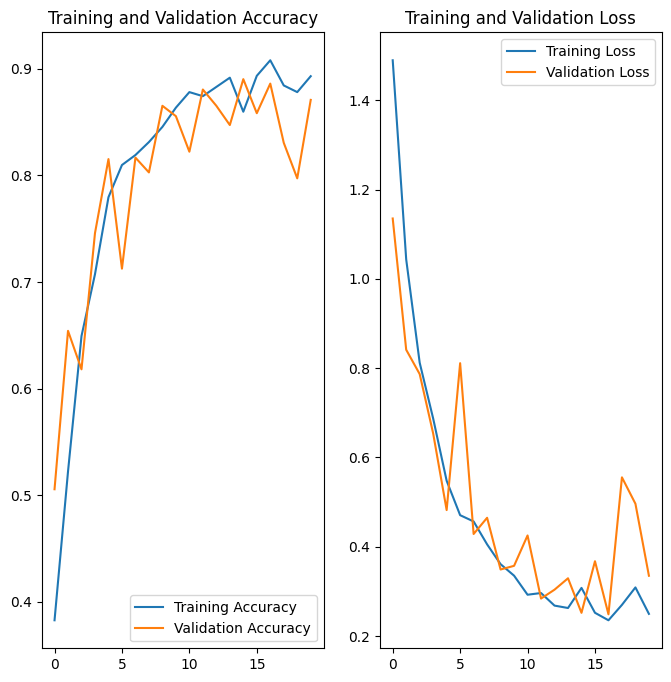

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

check from random internet

In [ ]:
sunflower_url = "https://th.bing.com/th/id/OIP.oa1AMH8OOCABeH6M71E-BAHaHa?pid=ImgDet&w=752&h=752&rs=1"
sunflower_path = tf.keras.utils.get_file('random_pic', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
test_image = [img_array]

In [ ]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

1/1 [==============================] - 0s 35ms/step


In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Folding_marks with a 99.61 percent confidence.


check_same sample

In [ ]:
s_path = "/content/content/Leather_Defect_Classification/loose_grains/Loose_grain_01_(1003).jpg"
img = tf.keras.utils.load_img(
    s_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
test_image.append(img_array)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 99ms/step
This image most likely belongs to loose_grains with a 97.05 percent confidence.


In [ ]:
predictions[0]

array([-0.17095703,  5.192076  , -4.166092  , -1.4535034 , -2.2970717 ,
       -2.0790966 ], dtype=float32)

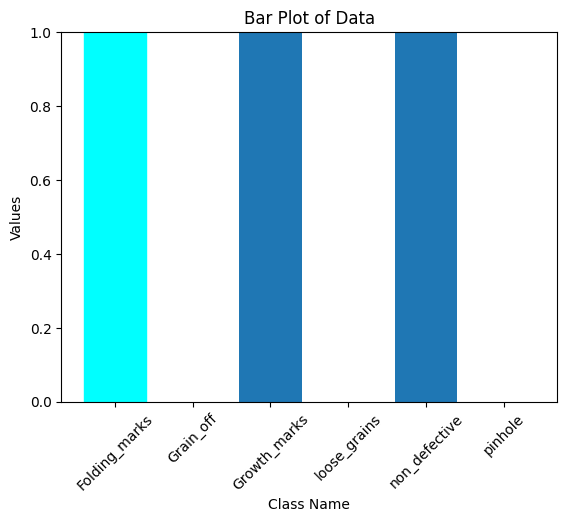

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = predictions[0]
class_name = class_names

# Create a bar plot
thisplot = plt.bar(class_name, data)
predicted_label = np.argmax(predictions)
plt.xticks(class_names,rotation = 45)
thisplot[predicted_label].set_color('cyan')
# Add labels and title
plt.xlabel('Class Name')
plt.ylabel('Values')
plt.title('Bar Plot of Data')
plt.ylim([0, 1])
# Display the plot
plt.show()



---
Serving Model


In [ ]:
import os

MODEL_DIR = "/content/model/" #tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

# model.save('fashion_model', save_format='tf')
# export_path = "/content/fashion_model/"
print('\nSaved model:')
!ls -l {export_path}


export_path = /content/model/1


Saved model:
total 344
drwxr-xr-x 2 root root   4096 Oct 11 12:13 assets
-rw-r--r-- 1 root root     58 Oct 11 12:13 fingerprint.pb
-rw-r--r-- 1 root root  28881 Oct 11 12:13 keras_metadata.pb
-rw-r--r-- 1 root root 303348 Oct 11 12:13 saved_model.pb
drwxr-xr-x 2 root root   4096 Oct 11 12:13 variables


In [ ]:
!saved_model_cli show --dir {export_path} --all

2023-10-11 12:13:42.310661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['sequential_3_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 180, 180, 3)
        name: serving_default_sequential_3_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['outputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 6)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/

In [ ]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update
!{SUDO_IF_NEEDED} apt upgrade
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-2.8.0/t/tensorflow-model-server/tensorflow-model-server_2.8.0_all.deb'
!dpkg -i tensorflow-model-server_2.8.0_all.deb
!pip3 install tensorflow-serving-api==2.8.0

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2943  100  2943    0     0  14521      0 --:--:-- --:--:-- --:--:-- 14497
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,026 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease


In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8502 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [ ]:
!tail server.log

2023-10-11 12:37:18.125394: E external/org_tensorflow/tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] tfg_optimizer{} failed: NOT_FOUND: Op type not registered 'DisableCopyOnRead' in binary running on 2b8a7bfc80ec. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib, accessing (e.g.) `tf.contrib.resampler` should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.
	when importing GraphDef to MLIR module in GrapplerHook
2023-10-11 12:37:18.231361: E external/org_tensorflow/tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] tfg_optimizer{} failed: NOT_FOUND: Op type not registered 'DisableCopyOnRead' in binary running on 2b8a7bfc80ec. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib, accessing (e.g.) `tf.co

Response check

In [ ]:
def show(idx, title):
  plt.figure()
  plt.imshow(idx)
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

In [ ]:
import json
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
data = json.dumps({"signature_name": "serving_default", "instances": test_image[0].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... 0, 17.0], [29.0, 19.0, 18.0], [29.0, 19.0, 18.0]]]]}


In [ ]:
import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8502/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

index = predictions[0].index(max(predictions[0]))
print(class_names[index])

Folding_marks
